In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2021 - 2024 United Kingdom Research and Innovation
#  Copyright 2021 - 2024 The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Mariam Demir (UKRI-STFC)

### Create AcquisitionGeometry Using Dataset Metadata
##### This example shows how to use the dataset's metadata to manually create and visualise the AcquisitionGeometry, and the AcquisitionData 

In [2]:
import os
from cil.io import TIFFStackReader
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.utilities.display import show_geometry
from cil.utilities.display import show2D
from zipfile import ZipFile
import numpy as np

Download and extract the file `SparseBeads_B12_L1` from Zenodo [here](https://zenodo.org/records/290117/files/SparseBeads_B12_L1.zip)

In [4]:
!wget -P ../data https://zenodo.org/records/290117/files/SparseBeads_B12_L1.zip

z = ZipFile(os.path.expanduser("../data/SparseBeads_B12_L1.zip"))
z.extractall(os.path.expanduser("../data/"))
!rm -rf ../data/SparseBeads_B12_L1.zip

--2024-11-01 19:41:14--  https://zenodo.org/records/290117/files/SparseBeads_B12_L1.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20588556 (20M) [application/octet-stream]
Saving to: ‘../data/SparseBeads_B12_L1.zip’

SparseBeads_B12_L1. 100%[===================>]  19.63M  62.5MB/s    in 0.3s    

2024-11-01 19:41:15 (62.5 MB/s) - ‘../data/SparseBeads_B12_L1.zip’ saved [20588556/20588556]



First let's load the raw data file and look at its properties:

In [5]:
file_name = '../data/SparseBeads_B12_L1/CentreSlice/Sinograms/SparseBeads_B12_L1_0001.tif'
data_reader = TIFFStackReader(file_name)
data = data_reader.read()

print(data, "\n", data.shape)

[[60369. 60004. 60659. ... 60414. 61058. 60764.]
 [60274. 60342. 60387. ... 60143. 60245. 60447.]
 [59631. 60254. 60189. ... 60455. 59983. 60137.]
 ...
 [62839. 62503. 62314. ... 62739. 62601. 63342.]
 [62693. 62364. 61960. ... 63250. 62819. 62583.]
 [62151. 63011. 62955. ... 62714. 62797. 62754.]] 
 (2520, 2000)


We can see the data is an array of pixel intensities of 2520 projections, containing 2000 horizontal pixels and a single vertical slice. 

We know this dataset has fan-beam geometry, so we create a Cone2D (a.k.a. fan-beam) AcquisitionGeometry object.

We need to specify the `source_position`, `detector_position`, and `detector_direction` used in the experiment.  
For this dataset, this metadata is stored in the file `SparseBeads_B12_L1.xtek2dct`. The location of the metadata may vary across systems and data-saving methods.

The following coordinates describe the source and detector positions:
* `SrcToObject=121.932688713074` 
* `SrcToDetector=1400.207` 

In CIL, the object (sample)'s coordinate is treated as the **0 position**.  
 The source position is therefore 0 - `SrcToObject`.  
 The detector position is `SrcToDetector` - `SrcToObject`.

Finally, we set the `num_pixels` to the number of horizontal pixels, and the `pixel_size`:

In [6]:
SrcToObject=121.932688713074
SrcToDetector=1400.207

src_coord = 0 - SrcToObject
detec_coord = SrcToDetector - SrcToObject

cone_geom = AcquisitionGeometry.create_Cone2D(source_position= [0, src_coord], 
                                              detector_position= [0, detec_coord], 
                                              detector_direction_x= [1, 0]) \
                                .set_panel(num_pixels=data.shape[1], pixel_size=[0.2, 0.2])

To complete the geometry information, we generate a list of angles based on the number of projections and the `AngularStep`:

In [7]:
Projections=2520
AngularStep=0.142857142857143

angles = np.linspace(0, Projections*AngularStep, Projections, endpoint=False)

cone_geom.set_angles(angles=angles)

Now we have created our geometry. We can visualise it to check that it looks accurate, with the correct shape and source/detector positions:

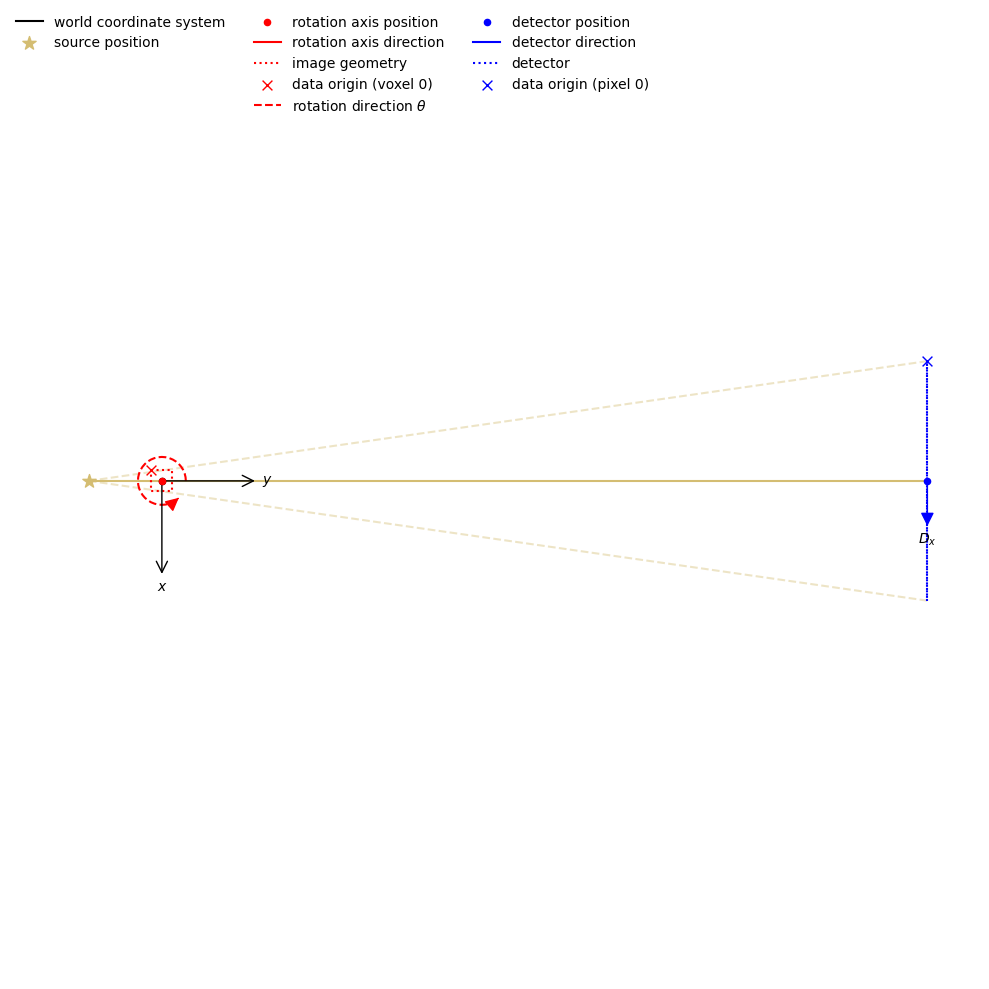

In [8]:
show_geometry(cone_geom)

In CIL, we store the data and the `AcquisitionGeometry` in an `AcquisitionData` object, which is needed to use many of CIL's reconstruction and visualisation tools:

In [57]:
sparse_beads = AcquisitionData(array=data, geometry=cone_geom)
print(sparse_beads)

Number of dimensions: 2
Shape: (2520, 2000)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



Using `show2D()`, we can view a central projection of the data:

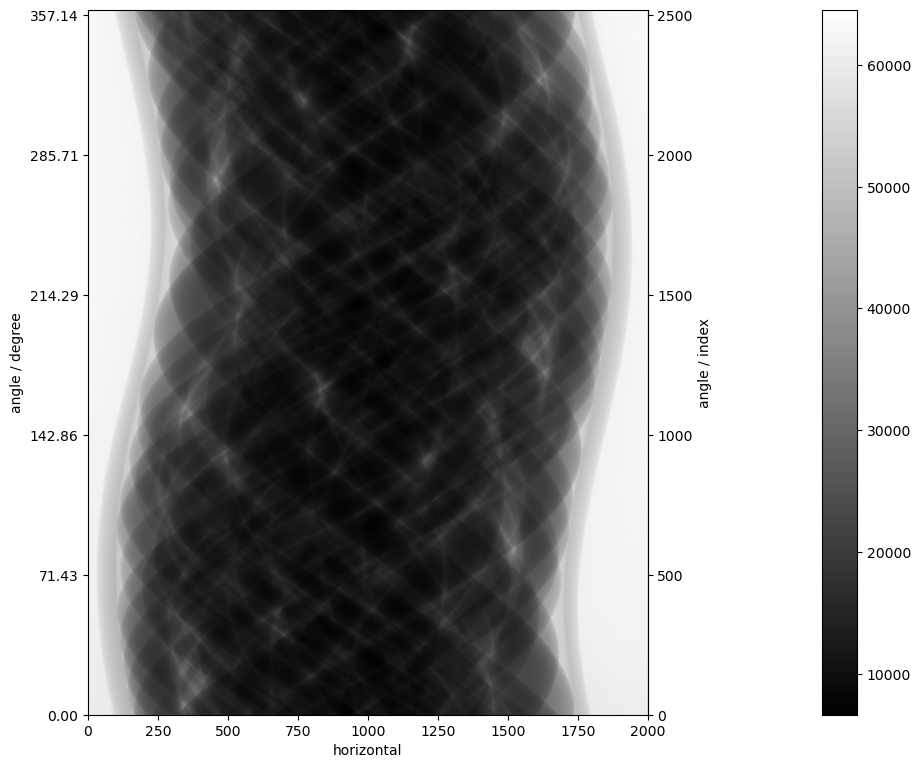

In [58]:
show2D(sparse_beads)

### Checking The Reconstruction
##### Below we use the FDK algorithm to reconstruct this dataset, and check that the geometry is correct:

In [59]:
from cil.recon import FDK
from cil.processors import TransmissionAbsorptionConverter

# Convert data to absorption data
sparse_beads = TransmissionAbsorptionConverter()(sparse_beads)

# Perform reconstruction
recon = FDK(sparse_beads).run()

# Apply a mask to show the beads only
recon.apply_circular_mask(0.9)


FDK recon

Input Data:
	angle: 2520
	horizontal: 2000

Reconstruction Volume:
	horizontal_y: 2000
	horizontal_x: 2000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False



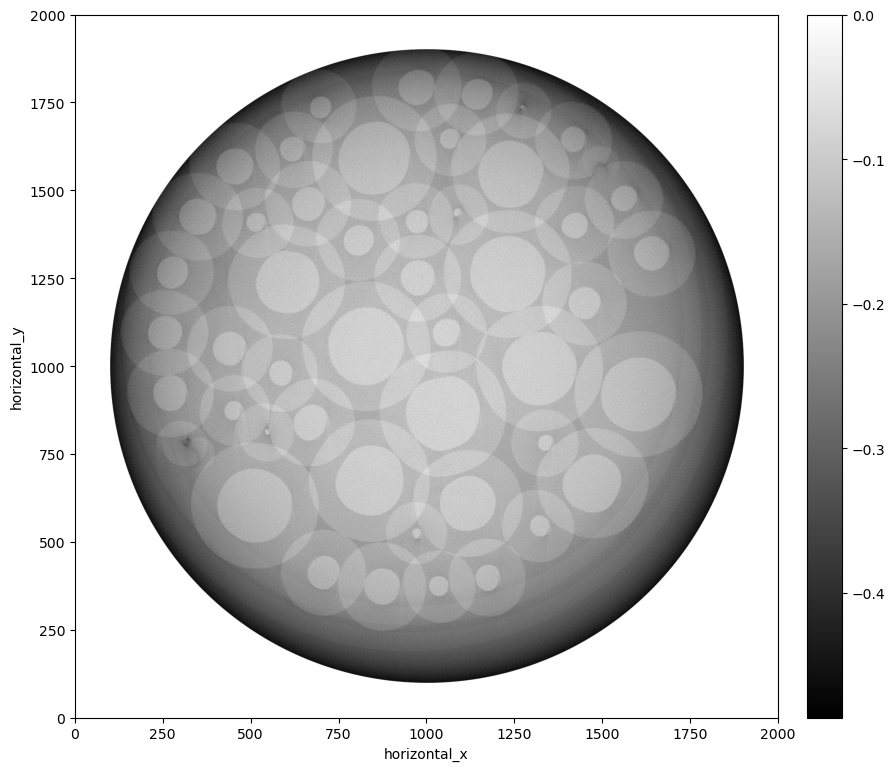

In [60]:
show2D(recon)

Above we can see that there are double edges over each bead, which indicates that the centre of rotation is slightly off.

We can use the `CentreOfRotationCorrector` processor to correct the centre of rotation offset, and perform the reconstruction again:

In [61]:
from cil.processors import CentreOfRotationCorrector

processor = CentreOfRotationCorrector.image_sharpness()
processor.set_input(sparse_beads)
centred_data = processor.get_output()

In [62]:
# Perform reconstruction
recon = FDK(centred_data).run()

# Apply a mask to show the beads only
recon.apply_circular_mask(0.9)

FDK recon

Input Data:
	angle: 2520
	horizontal: 2000

Reconstruction Volume:
	horizontal_y: 2000
	horizontal_x: 2000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False



Now the geometry is more accurate, and results in a more reasonable reconstruction without the double edges:

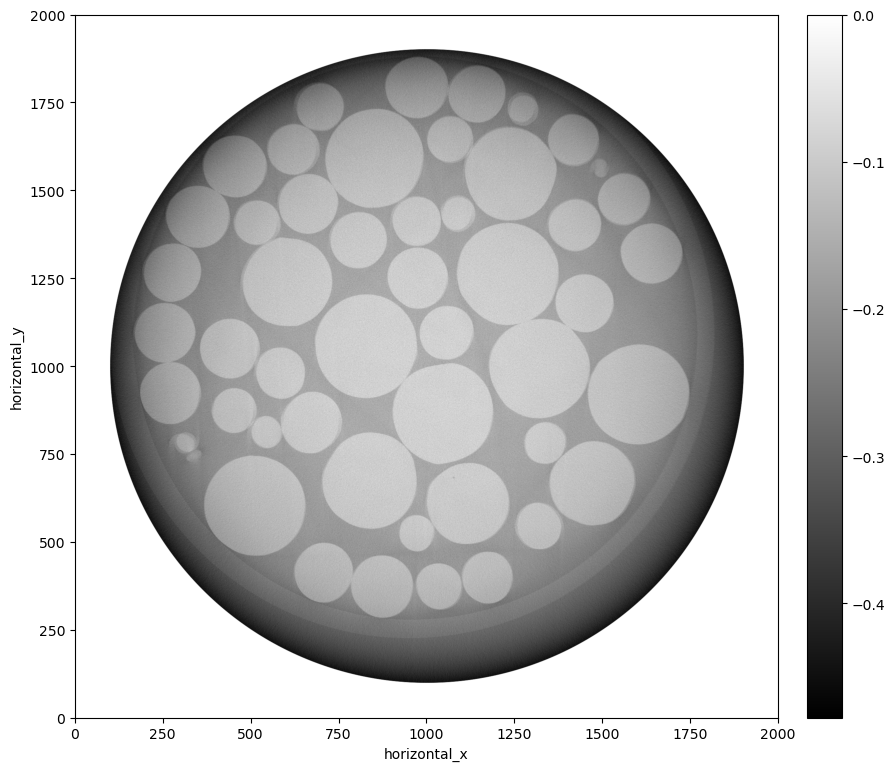

In [63]:
show2D(recon)